# **Inventory Management Analysis Overview**

This analysis delivers key insights for inventory management, enhanced with graphs and visuals for clarity.
The document is structured for ease of reading, however analysis was conducted in a dynamic, non-linear method.

#### **Document Structure:**
1. **Data Preparation:** Loading libraries, datasets, and initial data cleaning for analysis groundwork.
2. **Preliminary Results:** Creating essential tables and calculations.
3. **Report Preparation:** Preparing data for Power BI, focusing on actionable insights

<br>
<br>

## **Data Preparation**

### **Libraries**

In [543]:
import pandas as pd
import numpy as np

from IPython.display import Image
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"

### **Datasets**

In [544]:
excel_file = r"..\..\Portfolio Projects\Inventory Management\Datasets\WarmeHands - data.xlsx"

stock = pd.read_excel(excel_file, sheet_name="Stock")
orders = pd.read_excel(excel_file, sheet_name="Orders")
price = pd.read_excel(excel_file, sheet_name="Price")
costs = pd.read_excel(excel_file, sheet_name="Costs")

categories = pd.read_csv(r"..\..\Portfolio Projects\Inventory Management\Datasets\categories.csv")

### **Data Cleaning**
Set proper data types, handle with missing values, outliers, drop duplicates and adding calculated columns.

In [545]:
# stock table

stock["SKU-ID"] = stock["SKU-ID"].astype(str).str.replace(" ", "")
stock["Description"] = stock["Description"].str.title().str.strip()

In [546]:
# price table

price["ID"] = price["ID"].astype(str).str.replace(" ", "")
price["Retail_Price"] = pd.to_numeric(price["Retail_Price"].astype(str).str.replace("$", ""))

In [547]:
# categories table

categories_mapping = {"home acce" : "home accessories", "toys" : "toys & edibles"}
categories["category"] = categories["category"].map(categories_mapping).fillna(categories["category"]).astype("category")
categories["ID"] = categories["ID"].str.strip("SKU-")

In [548]:
# orders table

orders["SKU"] = orders["SKU"].astype(str).str.replace(" ", "")
orders["InvoiceDate"] = pd.to_datetime(orders["InvoiceDate"])
orders["Country"] = orders["Country"].str.split("_", expand=True)[1].str.strip(".")

In [549]:
# costs table

costs["SKU"] = costs["SKU"].astype(str).str.replace(" ", "")
costs["factory_equipment_rent"] = pd.to_numeric(costs["factory_equipment_rent"].str.replace("..", "."))

costs.drop_duplicates(inplace=True)
costs.reset_index(drop=True, inplace=True)

costs["COGS"] = costs["raw_material"] + costs["factory_labor"] + costs["factory_equipment_rent"]

<br>
<br>

## **Preliminary Results**

- **Workflow process.** For a better understanding of the workflow process, please become familiar with <a href="https://github.com/gnoevoy/Inventory_Management_Analysis/blob/main/README.md" target="_blank">the diagram</a>, which includes  the data transformation journey from initial preparation to the creation of reporting tables.

- **Key metrics.** All the necessary formulas for calculations were included to this document. For a more in-depth understanding, please refer to the <a href="https://github.com/gnoevoy/Inventory_Management_Analysis/blob/main/README.md" target="_blank">README section_x file.</a>

> *__Note:__ please be aware that some simple calculation were calculated in Power BI to take advantage of its interactive capabilities.*

### **Product table**

In [550]:
products = (
    pd.merge(stock, price, left_on="SKU-ID", right_on="ID", how="left")
    .merge(costs, left_on="SKU-ID", right_on="SKU", how="left")
    .merge(categories, left_on="SKU-ID", right_on="ID", how="left")
    [["SKU-ID", "Description", "category", "2020_units_sold", "2021_start_stock", "Retail_Price", "COGS"]]
)

In [551]:
# financial metrics for 2020

products["Revenue_2020"] = products["2020_units_sold"] * products["Retail_Price"]
products["COGS_2020"] = products["2020_units_sold"] * products["COGS"]
products["Profit_2020"] = products["Revenue_2020"] - products["COGS_2020"]
products["Pct_revenue_2020"] = (products["Revenue_2020"] / products["Revenue_2020"].sum() * 100).round(2)

products.head()

,SKU-ID,Description,category,2020_units_sold,2021_start_stock,Retail_Price,COGS,Revenue_2020,COGS_2020,Profit_2020,Pct_revenue_2020
0,82486,3 Drawer Antique White Wood Cabinet,decoration,440,917,13.32,8.95,5860.80,3938.00,1922.80,0.98
1,23435,3 Raffia Ribbons Vintage Christmas,decoration,692,1033,1.88,0.83,1300.96,574.36,726.60,0.22
2,85034B,3 White Choc Morris Boxed Candles,decoration,1610,1142,2.47,1.26,3976.70,2028.60,1948.10,0.66
3,84559A,3D Sheet Of Dog Stickers,toys & edibles,918,620,1.90,0.85,1744.20,780.30,963.90,0.29
4,23697,A Pretty Thank You Card,office & school,557,530,1.30,0.42,724.10,233.94,490.16,0.12


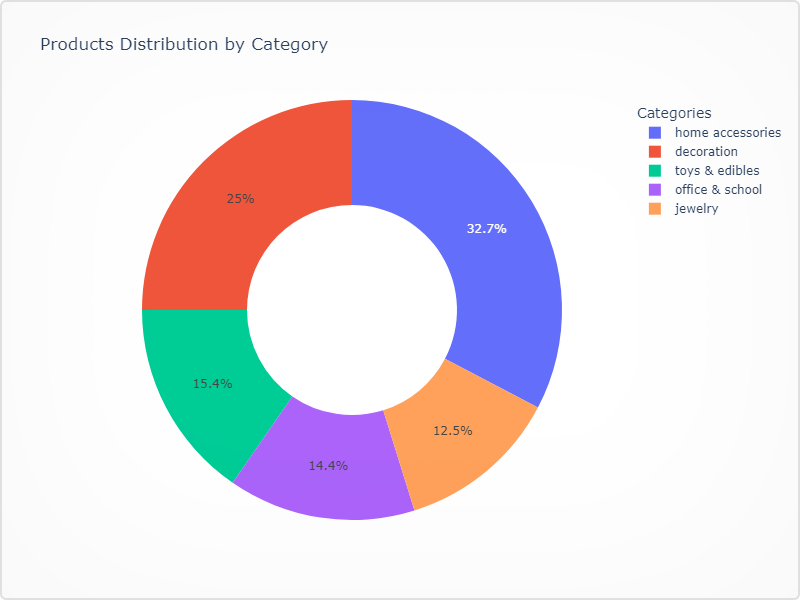

In [552]:
# Products Distribution by Category pie chart

fig = px.pie(
    products["category"].value_counts().reset_index(),
    names="category",
    values="count",
    title="Products Distribution by Category",
    hole=.5,
    width=800, height=600
)

fig.update_layout(legend_title_text="Categories")
# fig.show()

Image("images\Products Distribution by Category.png")

### **2021 Annual Sales**

In [553]:
sales = (
    orders[orders["InvoiceDate"].dt.year == 2021]
    .groupby("SKU")["Quantity"].sum()
    .to_frame("2021_units_sold").reset_index()
)

sales.head()

,SKU,2021_units_sold
0,10125,1149
1,15030,143
2,16054,1164
3,17014A,130
4,17038,1423


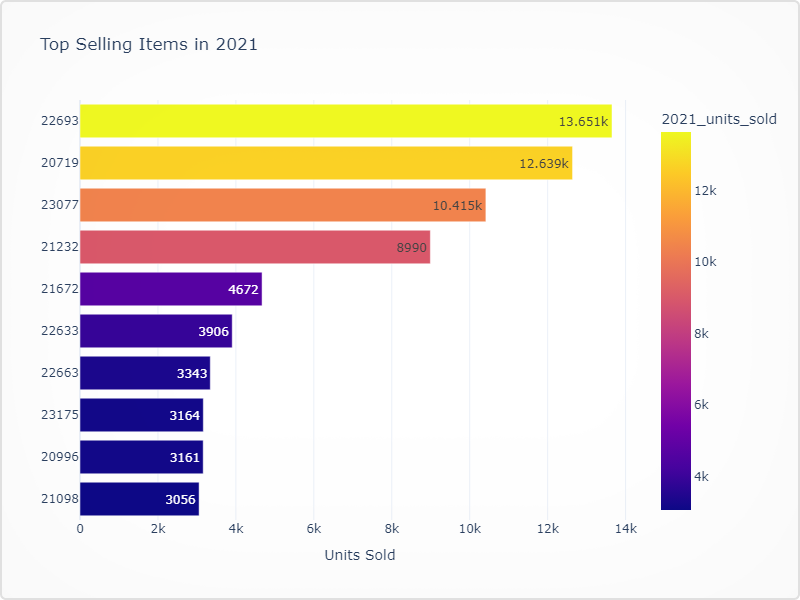

In [571]:
# Top Selling Items in 2021 bar chart

top_items = sales.sort_values("2021_units_sold", ascending=False).head(10)

fig = px.bar(
    top_items.sort_values("2021_units_sold"),
    x="2021_units_sold",
    y="SKU",
    title="Top Selling Items in 2021",
    color="2021_units_sold",
    text_auto=True,
    width=800, height=600
)

fig.update_layout(yaxis_title=None)
fig.update_layout(xaxis_title="Units Sold")
# fig.show()

Image("images\Top Selling Items in 2021.png")

### **Product sales for 2020 and 2021**

In [555]:
products_sales = pd.merge(products, sales, left_on="SKU-ID", right_on="SKU", how="left").drop(columns="SKU")

# financial metrics for 2021
products_sales["Revenue_2021"] = products_sales["2021_units_sold"] * products_sales["Retail_Price"]
products_sales["Pct_revenue_2021"] = (products_sales["Revenue_2021"] / products_sales["Revenue_2021"].sum() * 100).round(2)

#### **Inventory turnover rate for 2021**

**Turnover Rate** is a measure of how fast a company sells and replaces its inventory within a given period. A higher rate indicates more efficient inventory management.

$Inventory\ Turnover = \frac{ Units\ Sold}{Average\ Inventory\ Value}$

<br>

**Average Inventory Value** represents the average value of inventory held during the specific time period.

$Average\ Inventory = \frac{Start\ Stock + End\ Stock}{2}$

In [556]:
# ending stock level
products_sales["2021_end_stock"] = products_sales["2021_start_stock"] - products_sales["2021_units_sold"]

# average inventory value
products_sales["Avg_inventory"] = (
    ((products_sales["2021_start_stock"] + products_sales["2021_end_stock"]) * products_sales["COGS"] / 2).round(2)
)

# inventory turnover rate
products_sales["Inventory_turnover"] = (
    ((products_sales["2021_units_sold"] * products_sales["COGS"]) / products_sales["Avg_inventory"]).round(2)
)

products_sales.head()

,SKU-ID,Description,category,2020_units_sold,2021_start_stock,Retail_Price,COGS,Revenue_2020,COGS_2020,Profit_2020,Pct_revenue_2020,2021_units_sold,Revenue_2021,Pct_revenue_2021,2021_end_stock,Avg_inventory,Inventory_turnover
0,82486,3 Drawer Antique White Wood Cabinet,decoration,440,917,13.32,8.95,5860.80,3938.00,1922.80,0.98,742.0,9883.44,2.22,175.0,4886.70,1.36
1,23435,3 Raffia Ribbons Vintage Christmas,decoration,692,1033,1.88,0.83,1300.96,574.36,726.60,0.22,827.0,1554.76,0.35,206.0,514.19,1.33
2,85034B,3 White Choc Morris Boxed Candles,decoration,1610,1142,2.47,1.26,3976.70,2028.60,1948.10,0.66,888.0,2193.36,0.49,254.0,879.48,1.27
3,84559A,3D Sheet Of Dog Stickers,toys & edibles,918,620,1.90,0.85,1744.20,780.30,963.90,0.29,357.0,678.30,0.15,263.0,375.28,0.81
4,23697,A Pretty Thank You Card,office & school,557,530,1.30,0.42,724.10,233.94,490.16,0.12,456.0,592.80,0.13,74.0,126.84,1.51


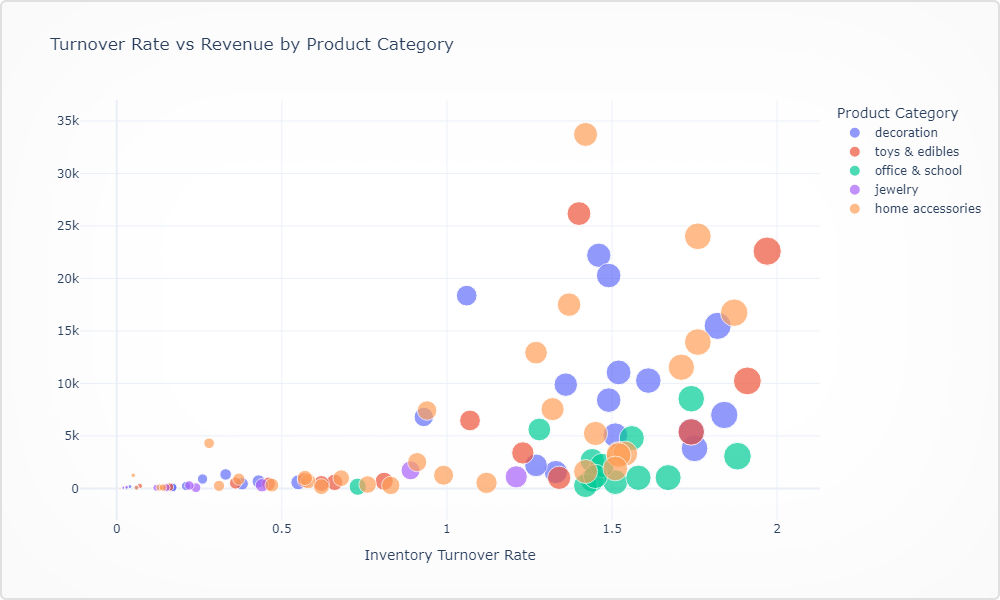

In [572]:
# Turnover Rate vs Revenue by Product Category scatter plot

fig = px.scatter(
    products_sales.dropna(),
    x="Inventory_turnover",
    y="Revenue_2021",
    size="Inventory_turnover",
    color="category",
    hover_name="Description",
    title="Turnover Rate vs Revenue by Product Category",
    width=1000, height=600
)

fig.update_layout(yaxis_title=None)
fig.update_layout(xaxis_title="Inventory Turnover Rate")
fig.update_layout(legend_title_text="Product Category")
# fig.show()

Image("images\Turnover Rate vs Revenue by Product Category.png")

### **ABC analysis for 2021**

**ABC Product Analysis** is a classification technique used to categorize products or items into different groups based on their importance to a business. "A" representing the most valuable  items while "C" representing the least. ABC categories are assigned to products based on their accumulated percentage of revenue:

- less than 70% - A category
- between 70% to 90% - B category 
- more than 90% - C category

In [558]:
abc_analysis = (
    products_sales.loc[:, ["SKU-ID", "category", "Description", "Revenue_2021", "Pct_revenue_2021"]]
    .sort_values("Pct_revenue_2021", ascending=False)
    .fillna({"Revenue_2021" : 0, "Pct_revenue_2021" : 0})
)

In [559]:
# accumulated % of revenue
abc_analysis["Accumulated_revenue_pct"] = abc_analysis["Pct_revenue_2021"].cumsum()

# abc categories
abc_analysis["ABC_category"] = np.where(
    abc_analysis["Accumulated_revenue_pct"] < 70, "A",
    np.where(abc_analysis["Accumulated_revenue_pct"].between(70, 90), "B", "C")
)

# ranking
abc_analysis["Rank"] = abc_analysis["Pct_revenue_2021"].rank(method="first", ascending=False).astype(int)

abc_analysis.head()

,SKU-ID,category,Description,Revenue_2021,Pct_revenue_2021,Accumulated_revenue_pct,ABC_category,Rank
42,22693,home accessories,Grow A Flytrap Or Sunflower In Tin,33717.97,7.56,7.56,A,1
86,22619,toys & edibles,Set Of 6 Soldier Skittles,26176.26,5.87,13.43,A,2
100,20719,home accessories,Woodland Charlotte Bag,24014.10,5.38,18.81,A,3
28,23077,toys & edibles,Doughnut Lip Gloss,22600.55,5.07,23.88,A,4
89,21232,decoration,Strawberry Ceramic Trinket Box,22205.30,4.98,28.86,A,5


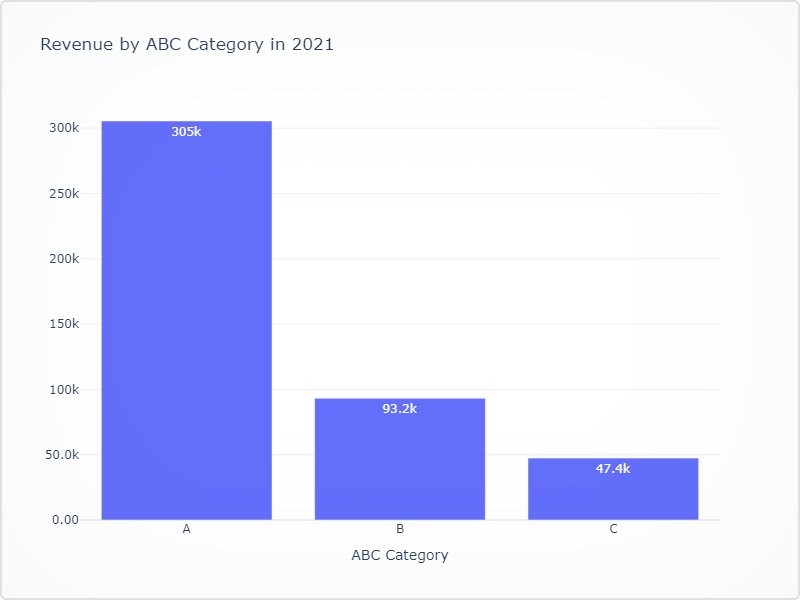

In [574]:
# Revenue by ABC Category in 2021 bar chart

revenue_by_abc = abc_analysis.groupby("ABC_category").agg(Revenue=("Revenue_2021", "sum")).reset_index()

fig = px.bar(
    revenue_by_abc,
    x="ABC_category",
    y="Revenue",
    title="Revenue by ABC Category in 2021",
    text_auto=True,
    width=800, height=600
)

fig.update_layout(yaxis_title=None)
fig.update_layout(xaxis_title="ABC Category")
fig.update_layout(yaxis_tickformat=".3s")
# fig.show()

Image("images\Revenue by ABC Category in 2021.png")

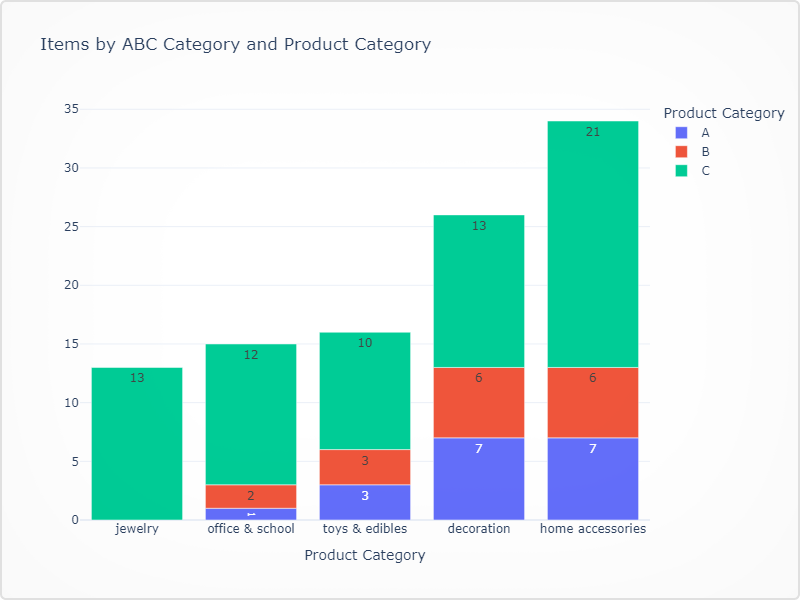

In [575]:
# Items by ABC Category and Product Category bar chart

items_by_abc = abc_analysis.groupby(["category", "ABC_category"]).agg(Products=("SKU-ID", "count")).reset_index()

fig = px.bar(
    items_by_abc.sort_values("Products"),
    x="category",
    y="Products",
    color="ABC_category",
    title="Items by ABC Category and Product Category",
    text_auto=True,
    width=800, height=600
)

fig.update_layout(yaxis_title=None)
fig.update_layout(xaxis_title="Product Category")
fig.update_layout(legend_title_text="Product Category")
# fig.show()

Image("images\Items by ABC Category and Product Category.png")

## Part 3 - Preparing tables for Report

### Product analysis

### Turn over rate by month

In [562]:
# month sales for each product

monthly_sales = (
    orders[orders["InvoiceDate"].dt.year == 2021]
    .groupby(["SKU", orders["InvoiceDate"].dt.month.rename("Month")])
    ["Quantity"].sum()
    .to_frame("units_sold").reset_index()
)

In [563]:
# all months mini-table (cross join)

month_data= pd.DataFrame({'Month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})
SKU_data = pd.DataFrame(list(monthly_sales["SKU"].unique()))

months = pd.merge(month_data, SKU_data, how="cross").rename(columns={0 : "SKU"})

In [564]:
monthly_sales = (
    pd.merge(months, monthly_sales, on=["Month", "SKU"], how="left")
    .fillna({"units_sold" : 0})
    .sort_values(["SKU", "Month"], ascending=True)
)

monthly_sales.head()

,Month,SKU,units_sold
0,1,10125,211.0
106,2,10125,9.0
212,3,10125,23.0
318,4,10125,152.0
424,5,10125,127.0


In [565]:
turnover = (
    pd.merge(products, monthly_sales, left_on="SKU-ID", right_on="SKU", how="left")
    .merge(abc_analysis[["SKU-ID", "ABC_category"]], on="SKU-ID", how="left")
    .drop(columns=["2020_units_sold", "Revenue_2020", "Profit_2020", "Pct_revenue_2020", "SKU"])
    .sort_values(["SKU-ID", "Month"], ascending=True)
)

In [566]:
# monthly inventory turnover rate

turnover["Accumulated_units"] = turnover.groupby("SKU-ID")["units_sold"].transform("cumsum")
turnover["end_stock"] = turnover["2021_start_stock"] - turnover["Accumulated_units"]
turnover["Avg_inventory"] = ((turnover["2021_start_stock"] + turnover["end_stock"]) * turnover["COGS"] / 2).round(2)
turnover["Inventory_turnover"] = ((turnover["units_sold"] * turnover["COGS"]) / turnover["Avg_inventory"]).round(2)

turnover.head()

,SKU-ID,Description,category,2021_start_stock,Retail_Price,COGS,COGS_2020,Month,units_sold,ABC_category,Accumulated_units,end_stock,Avg_inventory,Inventory_turnover
613,10125,Mini Tapes,office & school,1356,1.9,0.84,934.08,1.0,211.0,C,211.0,1145.0,1050.42,0.17
614,10125,Mini Tapes,office & school,1356,1.9,0.84,934.08,2.0,9.0,C,220.0,1136.0,1046.64,0.01
615,10125,Mini Tapes,office & school,1356,1.9,0.84,934.08,3.0,23.0,C,243.0,1113.0,1036.98,0.02
616,10125,Mini Tapes,office & school,1356,1.9,0.84,934.08,4.0,152.0,C,395.0,961.0,973.14,0.13
617,10125,Mini Tapes,office & school,1356,1.9,0.84,934.08,5.0,127.0,C,522.0,834.0,919.80,0.12


### Yearly turnover rate

In [567]:
categories_and_products = (
    pd.merge(products_sales, abc_analysis, on="SKU-ID", how="left")
    [["SKU-ID", "Description_x", "category_x", "Retail_Price", "COGS", "2021_units_sold", "Revenue_2021_x", "Pct_revenue_2021_x", "Inventory_turnover", "ABC_category", "Rank"]]
    .rename(columns={"Description_x" : "Description", "category_x" : "category", "Revenue_2021_x" : "Revenue_2021", "Pct_revenue_2021_x" : "Pct_revenue_2021",})
)

categories_and_products.head()

,SKU-ID,Description,category,Retail_Price,COGS,2021_units_sold,Revenue_2021,Pct_revenue_2021,Inventory_turnover,ABC_category,Rank
0,82486,3 Drawer Antique White Wood Cabinet,decoration,13.32,8.95,742.0,9883.44,2.22,1.36,A,17
1,23435,3 Raffia Ribbons Vintage Christmas,decoration,1.88,0.83,827.0,1554.76,0.35,1.33,C,45
2,85034B,3 White Choc Morris Boxed Candles,decoration,2.47,1.26,888.0,2193.36,0.49,1.27,C,41
3,84559A,3D Sheet Of Dog Stickers,toys & edibles,1.90,0.85,357.0,678.30,0.15,0.81,C,60
4,23697,A Pretty Thank You Card,office & school,1.30,0.42,456.0,592.80,0.13,1.51,C,63


### Year overview

### Years comparison

In [568]:
years_comparison = products_sales.loc[:, ["SKU-ID", "Retail_Price", "COGS", "2020_units_sold", "Revenue_2020", "Profit_2020", "Pct_revenue_2020", "2021_units_sold", "Revenue_2021", "Pct_revenue_2021"]]
years_comparison.head()

,SKU-ID,Retail_Price,COGS,2020_units_sold,Revenue_2020,Profit_2020,Pct_revenue_2020,2021_units_sold,Revenue_2021,Pct_revenue_2021
0,82486,13.32,8.95,440,5860.80,1922.80,0.98,742.0,9883.44,2.22
1,23435,1.88,0.83,692,1300.96,726.60,0.22,827.0,1554.76,0.35
2,85034B,2.47,1.26,1610,3976.70,1948.10,0.66,888.0,2193.36,0.49
3,84559A,1.90,0.85,918,1744.20,963.90,0.29,357.0,678.30,0.15
4,23697,1.30,0.42,557,724.10,490.16,0.12,456.0,592.80,0.13


### Regions distribution

In [569]:
sales_by_country = (
    orders[orders["InvoiceDate"].dt.year == 2021]
    .groupby(["SKU", "Country"])
    ["Quantity"].sum()
    .to_frame("2021_units_sold").reset_index()
)

sales_by_country.head()

,SKU,Country,2021_units_sold
0,10125,Australia,21
1,10125,Austria,20
2,10125,Belgium,23
3,10125,Cyprus,13
4,10125,Denmark,100


In [570]:
product_sales_by_country = (
    pd.merge(products, sales_by_country, left_on="SKU-ID", right_on="SKU", how="left")
    .merge(abc_analysis, on="SKU-ID", how="left")
    .drop(columns=["SKU", "2020_units_sold", "2021_start_stock", "Revenue_2020", "COGS_2020", "Profit_2020", "Pct_revenue_2020", "category_y", "Description_y", "Accumulated_revenue_pct", "Rank", "Pct_revenue_2021", "Revenue_2021"])
    .rename(columns={"category_x" : "category"})
)

product_sales_by_country.head()

,SKU-ID,Description_x,category,Retail_Price,COGS,Country,2021_units_sold,ABC_category
0,82486,3 Drawer Antique White Wood Cabinet,decoration,13.32,8.95,Australia,51.0,A
1,82486,3 Drawer Antique White Wood Cabinet,decoration,13.32,8.95,Belgium,39.0,A
2,82486,3 Drawer Antique White Wood Cabinet,decoration,13.32,8.95,Canada,5.0,A
3,82486,3 Drawer Antique White Wood Cabinet,decoration,13.32,8.95,Cyprus,18.0,A
4,82486,3 Drawer Antique White Wood Cabinet,decoration,13.32,8.95,Denmark,96.0,A


### Export tables fpr report 